In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
import file_utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seaborn version:  0.9.0


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [48]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [49]:
# earliest season data starts in 2002 corresponding to tournament season date of 2003
start_tournament = 2003
stop_tournament = 2018

In [50]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [51]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


### Opponent Plots

In [111]:
tourney_comp_ratings[(tourney_comp_ratings['season_t']==2018) & (tourney_comp_ratings['round']==64) &
                   ( ( tourney_comp_ratings['seed_t']== 1) |  ( tourney_comp_ratings['seed_o']== 1)) ]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
985,2018,64,2018-03-01 00:00:00.0000000,16,UMBC,32755362-6336-4dd3-ac34-6f72a6cc150b,74,1,Virginia,56913910-87f7-4ad7-ae3b-5cd9fb218fd9,54,1,2017,Win,-2.02,-3.84,0.694,73.0,68.0,0.443,0.646,77.344444,9.0,24.0,12.0,7.0,94.382991,17.0,22.21,9.07,0.912,67.0,54.0,0.460,0.754,68.070588,8.0,24.0,8.0,6.0,98.427238,13.0,America East,Atlantic Coast,189,168.0,125,176,140.0,184.0,123.0,111.0,155,2,2.0,1,1,1.0,1.0,1.0,1.0,1,0,1,1,5.0,13.0,-8.0,-0.017,1.0,0.0,-0.108,5.0,2.0,3.0,-0.218,-4.044247,4.0,15,-24.23,-12.91,187,166.0,124,175,139.0,183.0,122.0,110.0,154
993,2018,64,2018-03-01 00:00:00.0000000,1,Xavier,0d8a328f-20ce-410b-bed1-15fc01308aaf,102,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,83,1,2017,Win,19.08,9.45,0.829,84.0,74.0,0.492,0.779,80.948571,9.0,28.0,12.0,5.0,103.769589,24.0,-7.53,-5.53,0.444,77.0,79.0,0.438,0.725,81.288889,10.0,25.0,12.0,5.0,94.723893,25.0,Big East,Southwestern Athletic,12,9.0,4,6,3.0,14.0,4.0,3.0,13,242,240.0,265,296,249.0,249.0,276.0,222.0,256,1,0,1,10.0,-2.0,12.0,0.054,-1.0,3.0,0.054,7.0,7.0,0.0,0.385,9.045696,-1.0,-15,26.61,14.98,-230,-231.0,-261,-290,-246.0,-235.0,-272.0,-219.0,-243
1001,2018,64,2018-03-01 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,87,16,Radford,f2cf9ba2-ac8c-4d92-8e7a-48dd88e8f40b,61,1,2017,Win,26.64,10.24,0.900,86.0,70.0,0.500,0.779,78.830000,9.0,26.0,10.0,6.0,109.095522,17.0,-2.61,-4.08,0.639,67.0,64.0,0.425,0.725,74.627778,11.0,23.0,12.0,6.0,89.778903,17.0,Big East,Big South,1,1.0,2,2,2.0,2.0,2.0,2.0,2,191,170.0,149,184,160.0,170.0,158.0,128.0,165,1,0,1,16.0,3.0,13.0,0.075,-2.0,3.0,0.054,4.0,6.0,-2.0,0.261,19.316619,0.0,-15,29.25,14.32,-190,-169.0,-147,-182,-158.0,-168.0,-156.0,-126.0,-163
1009,2018,64,2018-03-01 00:00:00.0000000,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,76,16,Pennsylvania,e6c94452-1adf-4fb9-90e5-10f165c57c5a,60,1,2017,Win,21.39,11.87,0.795,81.0,71.0,0.492,0.708,78.923077,9.0,26.0,11.0,6.0,102.631579,16.0,2.24,-3.17,0.727,75.0,68.0,0.458,0.659,78.769697,8.0,28.0,11.0,5.0,95.214280,19.0,Big 12,Ivy,6,8.0,6,7,4.0,9.0,9.0,5.0,6,118,119.0,108,139,103.0,127.0,97.0,115.0,99,1,0,1,10.0,7.0,3.0,0.034,1.0,-2.0,0.049,5.0,6.0,-1.0,0.068,7.417299,-3.0,-15,19.15,15.04,-112,-111.0,-102,-132,-99.0,-118.0,-88.0,-110.0,-93


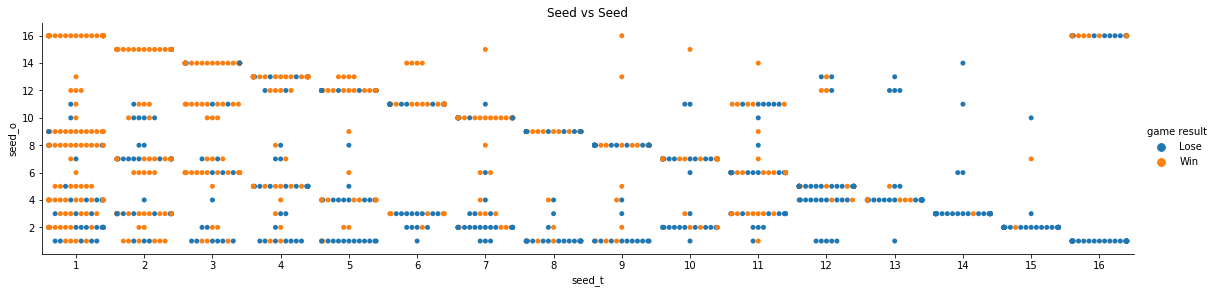

In [109]:
g = sns.catplot(x="seed_t", y="seed_o", hue="game result", 
                height=4, aspect=4,data=tourney_comp_ratings,kind='swarm')
plt.title('Seed vs Seed')
plt.show()

#### There should be an orange dot for seed_t =16, seed_o = 1 ....   (UMBC vs UVA 2018)

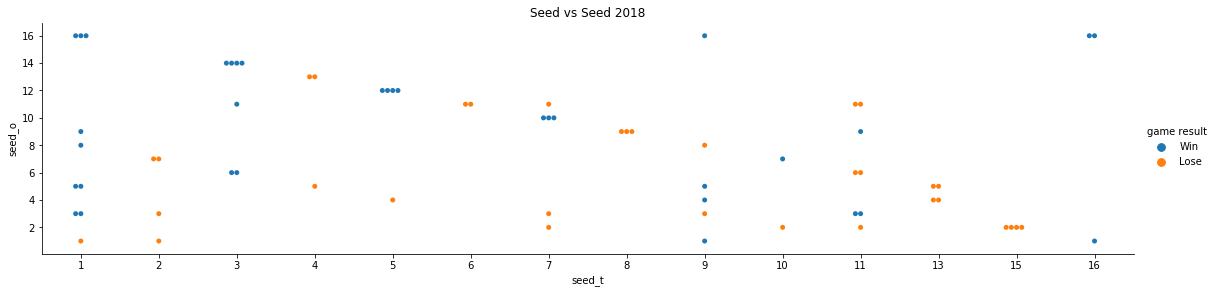

In [114]:
g = sns.catplot(x="seed_t", y="seed_o", hue="game result", 
                height=4, aspect=4,data=tourney_comp_ratings[tourney_comp_ratings['season_t']==2018],kind='swarm')
plt.title('Seed vs Seed 2018')
plt.show()

### Upset Plots

##### High Stats

In [95]:
total_games =0
tournament_games = {}
for year in range(start_tournament, stop_tournament+1, 1):
    tournament_games[year] = tourney_comp_ratings[tourney_comp_ratings['season_t'] == year].shape[0]
    total_games += tournament_games[year]
    
print('total games= ', total_games)

total games=  1045


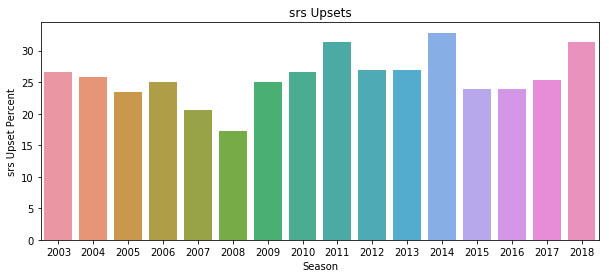

Percentage Tournament Game Upsets 25.837%




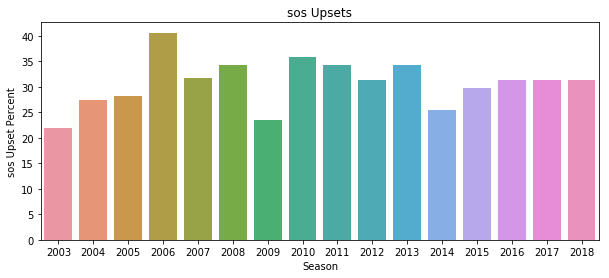

Percentage Tournament Game Upsets 30.813%




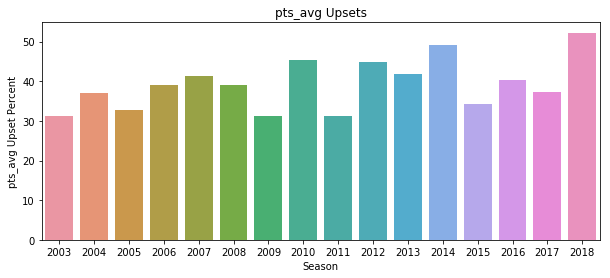

Percentage Tournament Game Upsets 39.330%




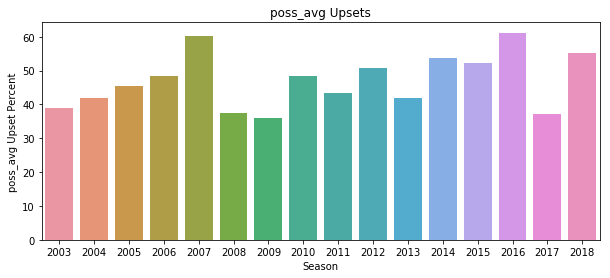

Percentage Tournament Game Upsets 47.081%




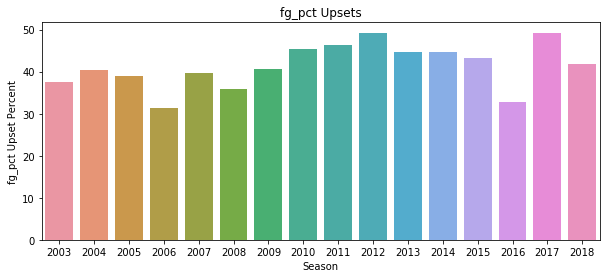

Percentage Tournament Game Upsets 41.435%




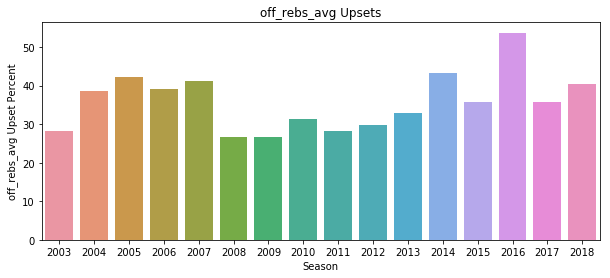

Percentage Tournament Game Upsets 35.885%




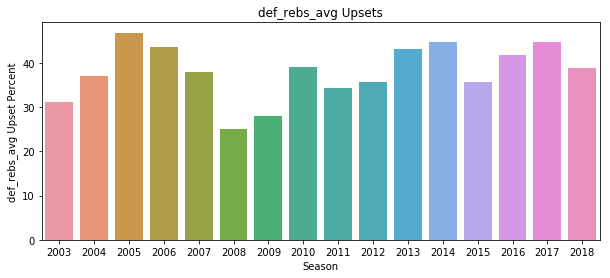

Percentage Tournament Game Upsets 38.086%




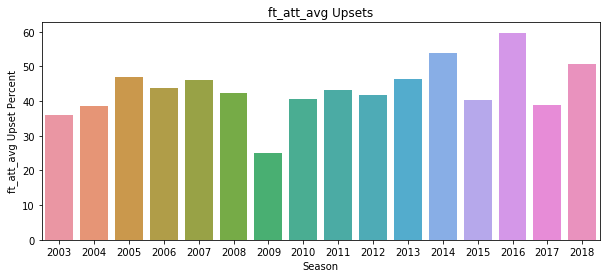

Percentage Tournament Game Upsets 43.445%




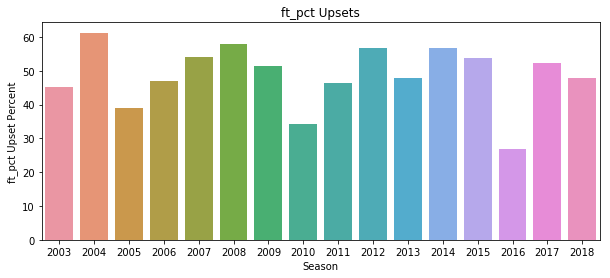

Percentage Tournament Game Upsets 48.612%




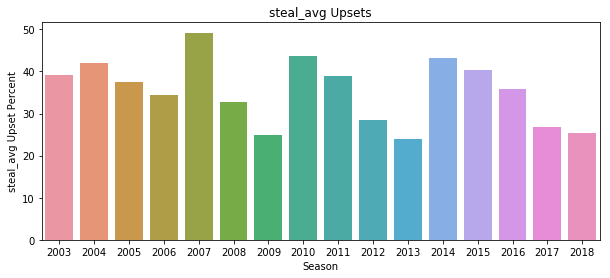

Percentage Tournament Game Upsets 35.311%




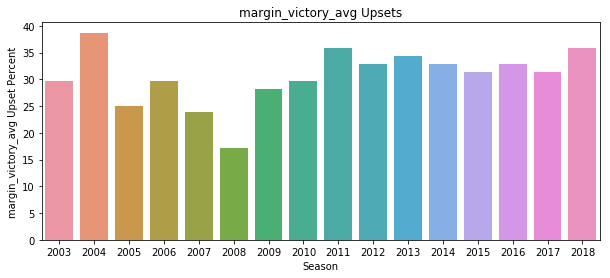

Percentage Tournament Game Upsets 30.622%




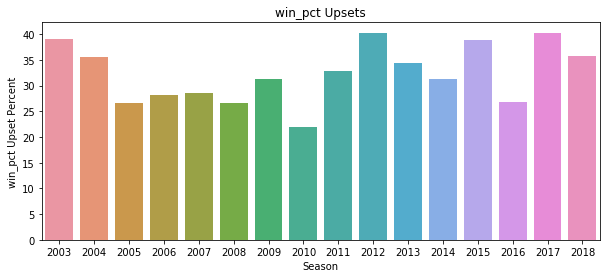

Percentage Tournament Game Upsets 32.440%




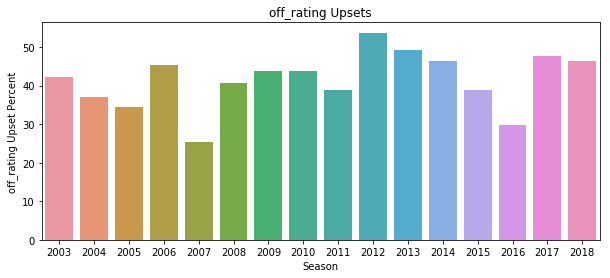

Percentage Tournament Game Upsets 41.531%




In [96]:
high_stats = feature_dictionary.get_high_stat_feature_labels()
for stat in high_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_comp_ratings['game_result'] == -1) & (tourney_comp_ratings[stat_t] > tourney_comp_ratings[stat_o])
    upset_cond_2 = (tourney_comp_ratings['game_result'] == 1) & (tourney_comp_ratings[stat_t] < tourney_comp_ratings[stat_o])
    upsets = tourney_comp_ratings[upset_cond_1 | upset_cond_2][['season_t', 'team_t','team_o','game_result',stat_t , stat_o ]]
    temp = upsets.season_t.value_counts().to_frame(name="count").reset_index()
    temp['percent'] = temp.apply(lambda x: 100.0 * x['count']/tournament_games[x['index']], axis=1)
    #print(upsets)
    
    plot = sns.barplot(x='index', y='percent',data=temp)
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.figure.set_figwidth(10)   
    plot.set_title(stat + " Upsets")
    plt.show()
    
    
    percent_upsets = upsets.shape[0]*100/total_games
    print("Percentage Tournament Game Upsets {:.3f}%".format( percent_upsets))
    print("\n")
    ratings_dict[stat] =  percent_upsets


##### Low Stat Upsets (The team that won had a greater number in these categories)

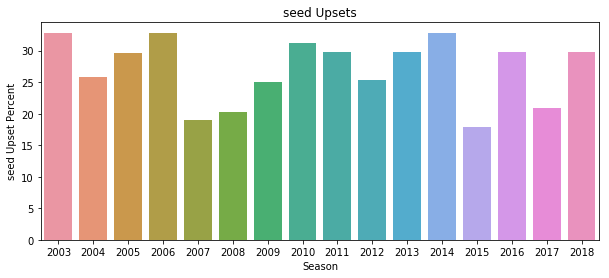

Percentage Tournament Game Upsets 27.081%
(seed correctly predicts 72.919%)




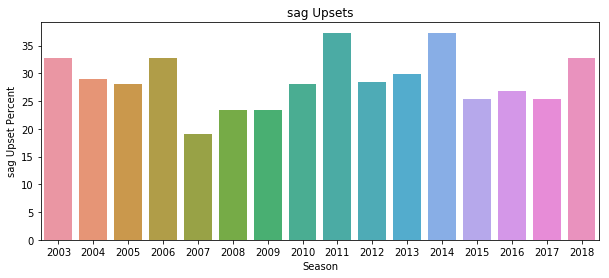

Percentage Tournament Game Upsets 28.804%
(sag correctly predicts 71.196%)




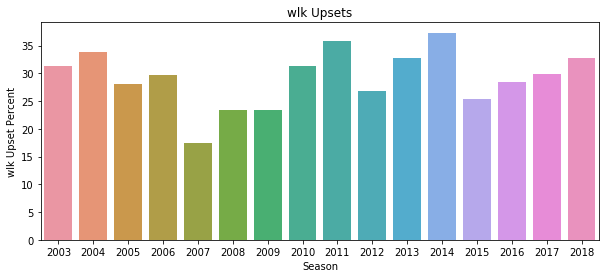

Percentage Tournament Game Upsets 29.282%
(wlk correctly predicts 70.718%)




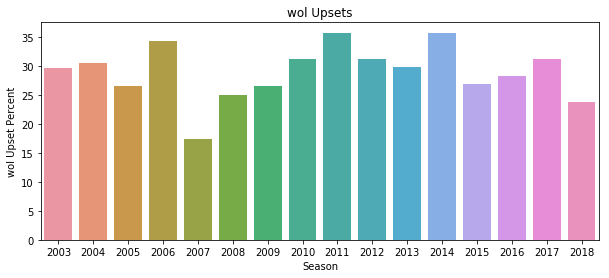

Percentage Tournament Game Upsets 29.091%
(wol correctly predicts 70.909%)




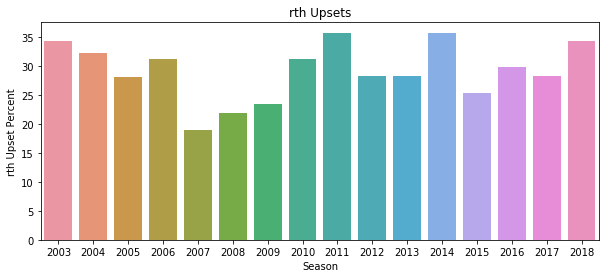

Percentage Tournament Game Upsets 29.282%
(rth correctly predicts 70.718%)




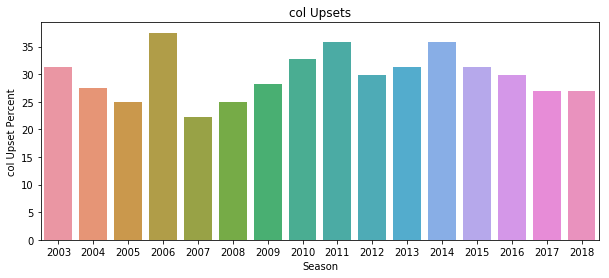

Percentage Tournament Game Upsets 29.856%
(col correctly predicts 70.144%)




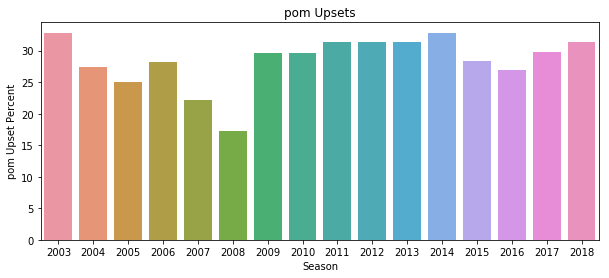

Percentage Tournament Game Upsets 28.517%
(pom correctly predicts 71.483%)




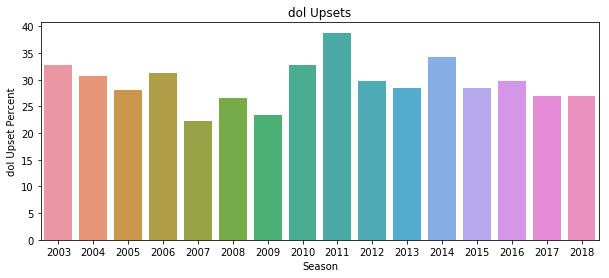

Percentage Tournament Game Upsets 29.474%
(dol correctly predicts 70.526%)




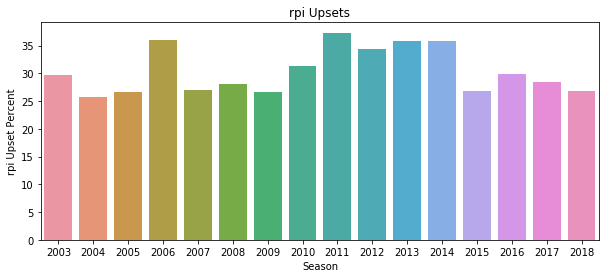

Percentage Tournament Game Upsets 30.431%
(rpi correctly predicts 69.569%)




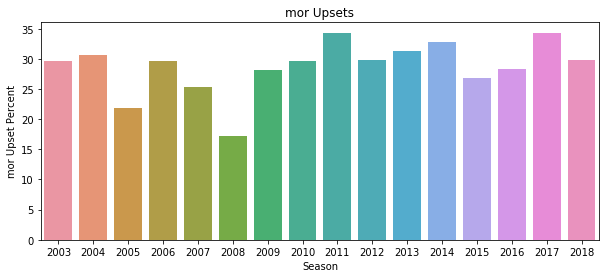

Percentage Tournament Game Upsets 28.804%
(mor correctly predicts 71.196%)




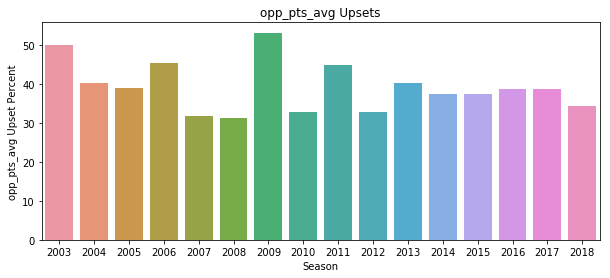

Percentage Tournament Game Upsets 39.234%
(opp_pts_avg correctly predicts 60.766%)




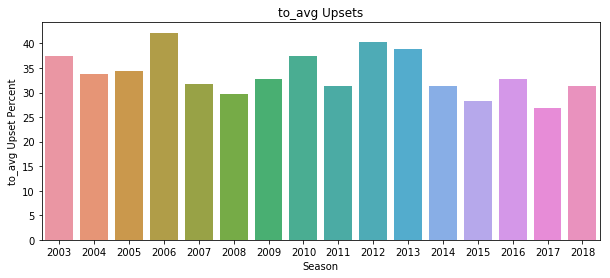

Percentage Tournament Game Upsets 33.780%
(to_avg correctly predicts 66.220%)




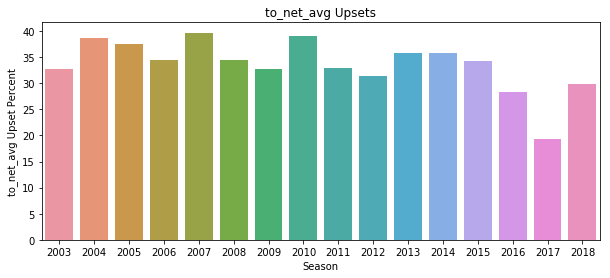

Percentage Tournament Game Upsets 33.493%
(to_net_avg correctly predicts 66.507%)




In [99]:
low_stats = feature_dictionary.get_low_stat_feature_labels()
for stat in low_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_comp_ratings['game_result'] == -1) & (tourney_comp_ratings[stat_t] < tourney_comp_ratings[stat_o])
    upset_cond_2 = (tourney_comp_ratings['game_result'] == 1) & (tourney_comp_ratings[stat_t] > tourney_comp_ratings[stat_o])
    upsets = tourney_comp_ratings[upset_cond_1 | upset_cond_2][['season_t', 'team_t','team_o','game_result',stat_t , stat_o ]]
    temp = upsets.season_t.value_counts().to_frame(name="count").reset_index()
    temp['percent'] = temp.apply(lambda x: 100.0 * x['count']/tournament_games[x['index']], axis=1)
    #print(upsets)
    
    plot = sns.barplot(x='index', y='percent',data=temp)
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.figure.set_figwidth(10)   
    plot.set_title(stat + " Upsets")
    plt.show()
    
    
    percent_upsets = upsets.shape[0]*100/total_games
    print("Percentage Tournament Game Upsets {:.3f}%".format( percent_upsets))
    print("(" + stat + " correctly predicts {:.3f}%)".format(100.0 - percent_upsets))
    print("\n")
    ratings_dict[stat] =  percent_upsets


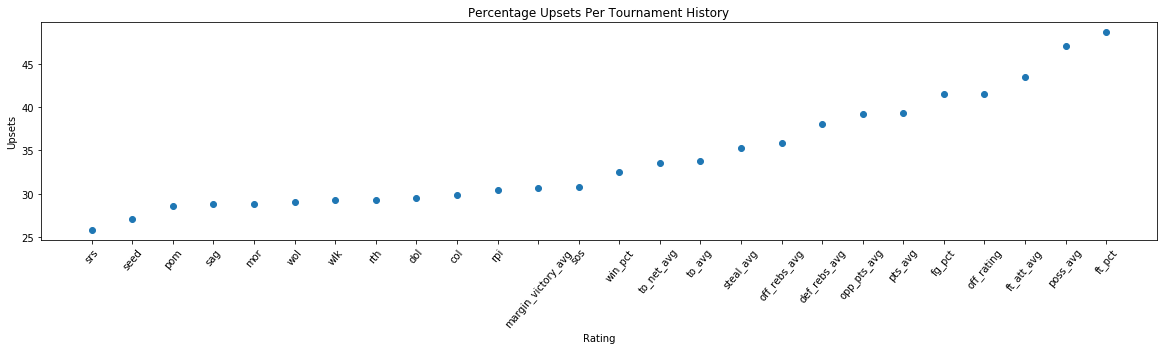

In [103]:
sorted_ratings = sorted(ratings_dict.items(), key=operator.itemgetter(1))
sorted_ratings
g= plt.scatter(*zip(*sorted_ratings))
plt.title('Percentage Upsets Per Tournament History')
plt.xlabel('Rating')
plt.ylabel('Upsets')
plt.xticks(rotation=50)
g.figure.set_size_inches(20,4)
plt.show()